In [3]:
import os
import numpy as np
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image
from PIL import ImageOps
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
input_dir = "D:\\FoodSeg103\\FoodSeg103\\Images\\img_dir\\train"
target_dir = "D:\\FoodSeg103\\FoodSeg103\\Images\\ann_dir\\train"

img_size = (160, 160)
num_classes = 104
batch_size = 2

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 4983
D:\FoodSeg103\FoodSeg103\Images\img_dir\train\00000000.jpg | D:\FoodSeg103\FoodSeg103\Images\ann_dir\train\00000000.png
D:\FoodSeg103\FoodSeg103\Images\img_dir\train\00000001.jpg | D:\FoodSeg103\FoodSeg103\Images\ann_dir\train\00000001.png
D:\FoodSeg103\FoodSeg103\Images\img_dir\train\00000002.jpg | D:\FoodSeg103\FoodSeg103\Images\ann_dir\train\00000002.png
D:\FoodSeg103\FoodSeg103\Images\img_dir\train\00000003.jpg | D:\FoodSeg103\FoodSeg103\Images\ann_dir\train\00000003.png
D:\FoodSeg103\FoodSeg103\Images\img_dir\train\00000004.jpg | D:\FoodSeg103\FoodSeg103\Images\ann_dir\train\00000004.png
D:\FoodSeg103\FoodSeg103\Images\img_dir\train\00000005.jpg | D:\FoodSeg103\FoodSeg103\Images\ann_dir\train\00000005.png
D:\FoodSeg103\FoodSeg103\Images\img_dir\train\00000006.jpg | D:\FoodSeg103\FoodSeg103\Images\ann_dir\train\00000006.png
D:\FoodSeg103\FoodSeg103\Images\img_dir\train\00000007.jpg | D:\FoodSeg103\FoodSeg103\Images\ann_dir\train\00000007.png
D:\FoodSeg103\Fo

In [26]:
!pip install labelme

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for labelme: filename=labelme-4.6.0-py3-none-any.whl size=1467822 sha256=6d5c2b949233371fa2dc53b6f34d2a56c79246938ce349231ea9daaf2aa2c01e
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\92\33\95\cd4f4c14e12d16fc0caa060385775687f7b69638030cceae44
  Created wheel for imgviz: filename=imgviz-1.4.1-py3-none-any.whl size=7675600 sha256=464b082a855f987ddc87bcf09d4b723c586c415f225783045553a0da2d4f740c
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\d4\5b\4a\61f801ac4bf2237b5369fc58aa862b3c6ba552bddc0214aeb9
Succes

ERROR: Could not install packages due to an OSError: [WinError 5] 存取被拒。: 'c:\\users\\user\\anaconda3\\envs\\tf2_gpu\\lib\\site-packages\\matplotlib\\backends\\_backend_agg.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [4]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets_fix(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = np.array(img)/255.
        y = np.zeros((self.batch_size,) + self.img_size + (104,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img_array = np.array(img)
            for z in np.unique(img_array):
                if z ==0:
                    continue
                label_mask = np.where(img_array==z,1,0)
                y[j,:,:,z] = label_mask  
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        return x, y

In [5]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=(160,160,3))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer


#     outputs = layers.Conv2D(3, kernel_size=1, strides=1, activation="sigmoid", padding="same")(x)
#     outputs = layers.Conv2D(num_classes, 2, activation="sigmoid", padding="same")(x)
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)
    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [6]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets_fix(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets_fix(batch_size, img_size, val_input_img_paths, val_target_img_paths)
test_train_gen =  OxfordPets_fix(
    batch_size, img_size, train_input_img_paths[0:32], train_target_img_paths[0:32]
)

In [428]:
#GPu memory 會暫滿，需要重啟
#把h5文件存下來，下次預測的時候再input進來
#IOU ， learning rate ，
import tensorflow as tf
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
# model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
# "binary_crossentropy"
# model.compile(optimizer=tf.keras.optimizers.Adam(
#     learning_rate=10e-6), loss=[focal_loss(alpha=.25, gamma=2)])
model.compile(optimizer=tf.keras.optimizers.Adam(
     learning_rate=0.0001), 
        loss=["binary_crossentropy"]
)

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation_fix_v10.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 50
training = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks,steps_per_epoch=200,validation_steps=200)

Epoch 1/50
200/200 [==============================] - 44s 206ms/step - loss: 0.0244 - val_loss: 0.0257


C:\Users\user\anaconda3\envs\tf2_gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
200/200 [==============================] - 33s 164ms/step - loss: 0.0243 - val_loss: 0.0257
Epoch 3/50
200/200 [==============================] - 31s 157ms/step - loss: 0.0238 - val_loss: 0.0258
Epoch 4/50
200/200 [==============================] - 31s 155ms/step - loss: 0.0238 - val_loss: 0.0248
Epoch 5/50
200/200 [==============================] - 32s 161ms/step - loss: 0.0238 - val_loss: 0.0246
Epoch 6/50
200/200 [==============================] - 32s 158ms/step - loss: 0.0231 - val_loss: 0.0251
Epoch 7/50
200/200 [==============================] - 31s 156ms/step - loss: 0.0229 - val_loss: 0.0242
Epoch 8/50
200/200 [==============================] - 31s 155ms/step - loss: 0.0234 - val_loss: 0.0241
Epoch 9/50
200/200 [==============================] - 30s 151ms/step - loss: 0.0227 - val_loss: 0.0246
Epoch 10/50
200/200 [==============================] - 30s 148ms/step - loss: 0.0237 - val_loss: 0.0255
Epoch 11/50
200/200 [==============================] - 30s 149ms/step - 

In [429]:
model = keras.models.load_model("oxford_segmentation_fix_v10.h5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [490]:
val_gen = OxfordPets_fix(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen[2][0])

In [470]:
val_gen[1][0].shape

(2, 160, 160, 3)

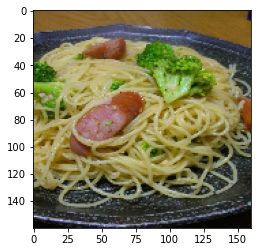

In [491]:
img = val_gen[2][0][0]
plt.imshow(img)

In [10]:
val_preds.shape

(2, 160, 160, 104)

In [20]:
val_preds[0].shape

(160, 160, 104)

In [11]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.imshow(mask[:,:,1])
    print(mask.shape)
    print(mask[:,:,0])
    print(np.unique(mask))

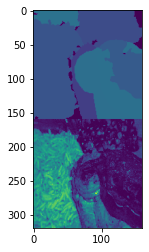

In [101]:
import cv2
# add_image = np.concatenate( (np.array(img),np.array(img_o)[:,:,2]) )
add_image = np.concatenate( (np.array(img),np.array(img_o)[:,:,2]) )
plt.imshow(add_image)
# add_image = np.array(img)+np.array(img_o)

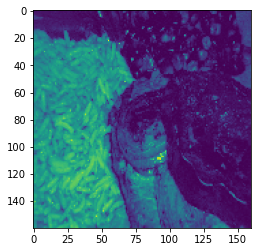

In [99]:
# np.array(img_o).shape
plt.imshow(np.array(img_o)[:,:,2])

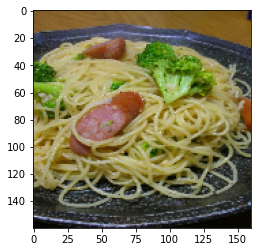

In [487]:
i =4
img_o = load_img(val_input_img_paths[i], target_size=img_size)
plt.imshow(img_o)

[ 0 49 65 87]


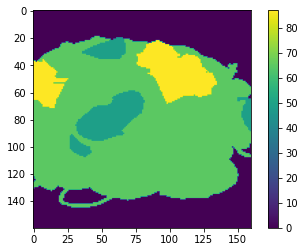

In [496]:
from PIL import Image
img = load_img(val_target_img_paths[i], target_size=img_size, color_mode="grayscale")
test_img = Image.fromarray(np.array(img))
test_img.save('test_img.jpg')
plt.imshow(test_img)
plt.colorbar()
print(np.unique(np.array(img)))

In [394]:
color_list = np.array(
    [ [210, 55, 55],  
     [210, 210, 55],
     [55, 210, 55],
     [55, 210, 210],
     [55, 55, 210],
     [171, 55, 210],
     [210, 55, 133],
    ] )


color_list[0][0]


210

(160, 160, 3)
[ 0 49 65 87]


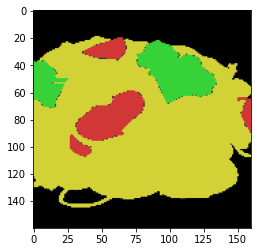

In [521]:
color_mask(val_target_img_paths[i])

In [520]:
def color_mask(path):
    img_a = cv2.imread(path)
    img_a = cv2.resize(img_a, (160,160) )
    rgb = cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB)
    rgb_test = rgb
    print(rgb.shape)
    label = np.unique(np.array(img))
    print(label)
    
    color_index = 0;
    for z in label:
        if z ==0:
            continue
        rgb_test[:,:,0] = np.where(rgb[:,:,0]==z, color_list[color_index][0], rgb[:,:,0])
        rgb_test[:,:,1] = np.where(rgb[:,:,1]==z, color_list[color_index][1], rgb[:,:,1])
        rgb_test[:,:,2] = np.where(rgb[:,:,2]==z,color_list[color_index][2], rgb[:,:,2])
        color_index+=1
    rgb_test = Image.fromarray(rgb_test)

    rgb_test.save('rgb_test.jpg')
    plt.imshow(rgb_test)

(160, 160, 3)
[ 0 49 65 87]


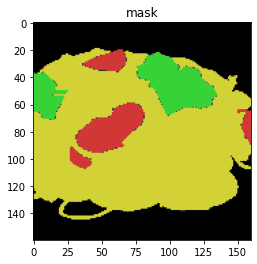

In [556]:
img_a = cv2.imread(val_target_img_paths[i])
img_a = cv2.resize(img_a, (160,160) )
rgb = cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB)
print(rgb.shape)
label = np.unique(np.array(img))
print(label)
rgb_test = rgb

color_index = 0;
for z in label:
    if z ==0:
        continue
    rgb_test[:,:,0] = np.where(rgb[:,:,0]==z, color_list[color_index][0], rgb[:,:,0])
    rgb_test[:,:,1] = np.where(rgb[:,:,1]==z, color_list[color_index][1], rgb[:,:,1])
    rgb_test[:,:,2] = np.where(rgb[:,:,2]==z,color_list[color_index][2], rgb[:,:,2])
    color_index+=1
# for z in label:
#     if z ==0:
#         continue
#     text="Test"
#     cv2.putText(rgb_test, text, (10, 40), cv2.FONT_HERSHEY_SIMPLEX,
#       0.6, (0, 0, 0), 1, cv2.LINE_AA)

rgb_test = Image.fromarray(rgb_test)

plt.title('mask')
rgb_test.save('rgb_test.jpg')
plt.imshow(rgb_test)
# rgb[:,:,0]
# coordinate = rgb[0]
# coordinate

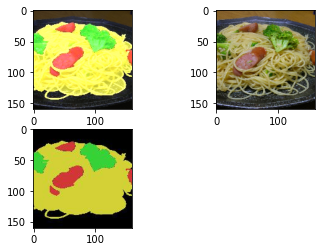

In [526]:
color_show("rgb_test.jpg",val_input_img_paths[i])

In [523]:
def color_show(path_a, path_b):   
    img_a = cv2.imread(path_a)
    img_a = cv2.resize(img_a, (160,160) )
    img_b = cv2.imread(path_b)
    img_b = cv2.resize(img_b, (160,160) )
    # cv2.waitKey(0)
    # cv2.imshow('mg_A',img_a)
    # cv2.destroyAllWindows()

    dst = cv2.addWeighted(img_a, 0.9, img_b, 0.5, 5.0)
    gray = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    img_b=cv2.cvtColor(img_b,cv2.COLOR_BGR2RGB)
    img_a=cv2.cvtColor(img_a,cv2.COLOR_BGR2RGB)
    plt.subplot(2, 2, 1)
    plt.imshow(gray)
    plt.subplot(2, 2, 2)
    plt.imshow(img_b)
    plt.subplot(2, 2, 3)
    plt.imshow(img_a) 

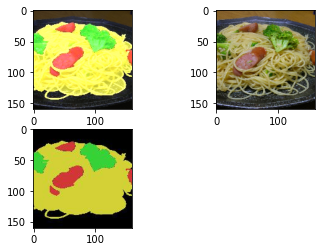

In [522]:
# new_image = cv2.addWeighted(img,0.3,img_o,0.7,0)
img_a = cv2.imread("rgb_test.jpg")
img_a = cv2.resize(img_a, (160,160) )
img_b = cv2.imread(val_input_img_paths[i])

img_b = cv2.resize(img_b, (160,160) )
# cv2.waitKey(0)
# cv2.imshow('mg_A',img_a)
# cv2.destroyAllWindows()

dst = cv2.addWeighted(img_a, 0.9, img_b, 0.5, 5.0)
gray = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
img_b=cv2.cvtColor(img_b,cv2.COLOR_BGR2RGB)
img_a=cv2.cvtColor(img_a,cv2.COLOR_BGR2RGB)
plt.subplot(2, 2, 1)
plt.imshow(gray)
plt.subplot(2, 2, 2)
plt.imshow(img_b)
plt.subplot(2, 2, 3)
plt.imshow(img_a)

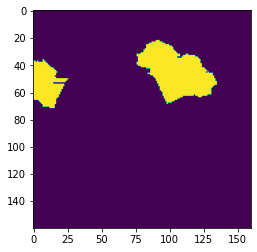

In [538]:
img = load_img(val_target_img_paths[i], target_size=img_size, color_mode="grayscale")
img_array = np.array(img)
img_array_mask = np.where(img_array==87,1,0)
img_array_mask.shape
plt.imshow(img_array_mask)

In [21]:
val_preds[i][:,:,0].shape

IndexError: index 3 is out of bounds for axis 0 with size 2

(160, 160, 104)
-----------


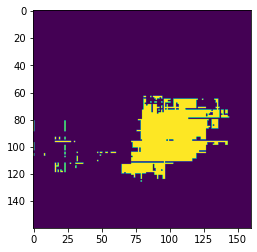

In [557]:
test = val_preds[0]
test_mask = test[:,:,65]
test_threshold = np.where(test_mask > np.percentile(test_mask,90),1,0)
# test_threshold = np.where(test_mask,1,0)
# test_threshold = np.where(test_mask ,test_mask,0)
print(test.shape)
print("-----------")

plt.imshow(test_threshold)
# test[:,:,47].shape

In [448]:
val_preds.shape

(2, 160, 160, 104)

In [ ]:
np.save('pred_mask.npy', test)